# Fiber Assignment Efficiency

Look for variations in the fiber-assignment efficiency of individual robots. For example, how do expanded keepouts or non-functional neighbors influence the probability that a (non-sky) target is assigned to a particular fiber?

Use the [fiberassign-TILEID.fits.gz files](https://desidatamodel.readthedocs.io/en/latest/DESI_TARGET/fiberassign/tiles/TILES_VERSION/TILEXX/fiberassign-TILEID.html) for the authoritative information on fiber assignment success and run date. Use [tiles-SPECPROD.html](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html) for a list of all tiles.

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fitsio
import astropy.time

In [3]:
import fpoffline.array
import fpoffline.io
import fpoffline.const

## Initialization

Define the path to use for reading fiberassignment outputs:

In [4]:
FA_PATH = Path('/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/')
assert FA_PATH.exists()

Define the path to use for pipeline outputs:

In [5]:
REDUX = Path(f'/global/cfs/cdirs/desi/spectro/redux/')
assert REDUX.exists()

Break the survey into contiguous runs at shutdown boundaries. The final boundary is ~today for the current run (so update this value to include more recent data).

In [6]:
breaks = [
    pd.Timestamp(date, tz='UTC') for date in
    ( '2021-09-01', '2022-08-01', '2023-08-01', '2024-05-01', '2024-09-25' )
]

Load snapshots of the focal plane state at each breakpoint.

In [7]:
def load_snapshots():
    
    snaps = [ ]
    # Older snapshots use an invalid datatype 'object' for the 'FIXED_NEIGHBORS' column,
    # which generates warnings that we ignore here.
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='unexpected datatype')
        for when in breaks:
            snap = fpoffline.io.get_snapshot(timestamp=astropy.time.Time(when.to_pydatetime()), maxage_days=60)
            snaps.append(snap)
    return snaps

snaps = load_snapshots()

Load the current focalplane index table. We will need this below for the map of positioners to fiberblocks.

In [8]:
FPINDEX = fpoffline.io.get_index().to_pandas()

## Summarize Tiles

Get the date on which each tile was designed. Ideally we could use the tile summary file for this, but it does not contain this info. Instead, we scan through the logfiles for each run of fiberassign looking for the `rundate` keyword. This is much faster (but still slow) than opening the corresponding compressed FITS files, which also contain this info. Save the results to a CSV file. You can read this file back using:
```
tile_rundates = pd.read_csv('tile-rundates.csv', index_col='tileid', parse_dates=['rundate'])
```

In [664]:
def get_tile_rundates(outfile='tile-rundates.csv', maxlines=100):
    
    token = 'rundate='
    k0 = len(token)
    with open(outfile, 'w') as out:
        print('tileid,rundate', file=out)
        for group in sorted(FA_PATH.glob('???')):
            try:
                nnn = int(group.name)
                print(f'Scanning {group.name}nnn...')
            except ValueError:
                # silently ignore any other subdirs
                pass
            for logfile in sorted(group.glob(f'fiberassign-{group.name}???.log')):
                tileid = int(logfile.name[12:18])
                with open(logfile, 'r') as f:
                    found = False
                    for i in range(maxlines):
                        line = f.readline()
                        k = line.find(token)
                        if k >= 0:
                            start = line[k+k0:]
                            if start[10] != 'T':
                                print(f'Missing iso T on line {i} of {logfile}: {start[:19]}')
                            try:
                                timestamp = pd.Timestamp(start[:19], tz='UTC')
                            except Exception:
                                print(f'Invalid RUNDATE on line {i} of {logfile}: {start[:19]}')
                                break
                            found = True
                            break
                    if not found:
                        print(f'No RUNDATE found in {logfile}')
                        continue
                print(f'{tileid},"{timestamp}"', file=out)

%time get_tile_rundates()

Scanning 000nnn...
Scanning 001nnn...
Scanning 002nnn...
Scanning 003nnn...
Scanning 004nnn...
Scanning 005nnn...
Scanning 006nnn...
Scanning 007nnn...
Scanning 008nnn...
Scanning 009nnn...
Scanning 010nnn...
Scanning 011nnn...
Scanning 020nnn...
Scanning 021nnn...
Scanning 022nnn...
Scanning 023nnn...
Scanning 024nnn...
Scanning 025nnn...
Scanning 026nnn...
Scanning 027nnn...
Scanning 040nnn...
Scanning 041nnn...
Scanning 042nnn...
Scanning 043nnn...
Scanning 059nnn...
Scanning 060nnn...
Scanning 063nnn...
Scanning 065nnn...
Scanning 066nnn...
Scanning 067nnn...
Scanning 068nnn...
Scanning 070nnn...
Scanning 074nnn...
Scanning 078nnn...
Scanning 080nnn...
Scanning 081nnn...
Scanning 082nnn...
Scanning 083nnn...
CPU times: user 1.73 s, sys: 2.45 s, total: 4.18 s
Wall time: 4min 43s


Load the tile summary file and add a rundate column. Use a specific release and only consider tiles from a specific survey. Produce a plot of integrated tile designs versus run date.

Loaded 14366 tiles for survey "main" from release "daily"
Ignoring 10 tiles without rundates. Re-run get_tile_rundates() to include these.


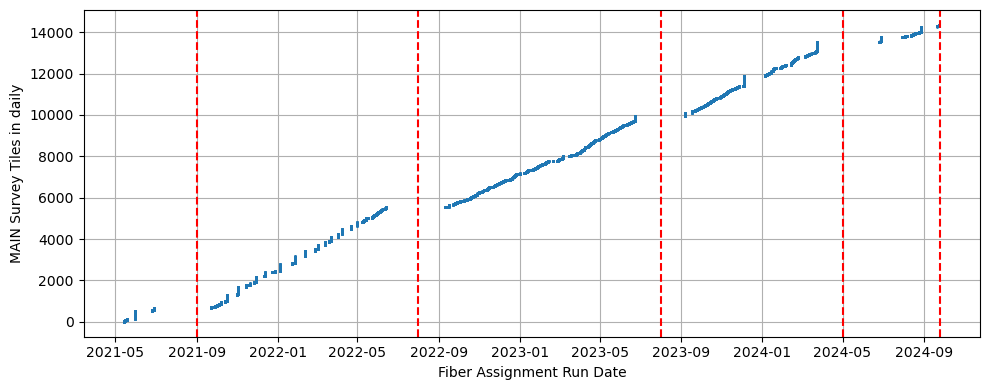

In [10]:
def get_tile_info(release='daily', survey='main', save=None):
    
    # read the rundates for each tile design
    df = pd.read_csv('tile-rundates.csv', index_col='tileid', parse_dates=['rundate'])
    
    # load the tile metadata for the requested survey
    path = REDUX / release
    assert path.exists()
    fitspath = path / f'tiles-{release}.fits'
    csvpath = path / f'tiles-{release}.csv'
    if fitspath.exists():
        tiles = fitsio.read(str(fitspath), ext=1)
        sel = tiles['SURVEY'] == survey
        tiles = pd.DataFrame(tiles[sel].byteswap().newbyteorder())
    elif csvpath.exists():
        tiles = pd.read_csv(csvpath)
        sel = tiles.SURVEY == survey
        tiles = tiles[sel]
    else:
        print(f'No tiles file found for release "{release}"')
        return
    print(f'Loaded {len(tiles)} tiles for survey "{survey}" from release "{release}"')

    # ignore tiles that are not in our rundates file (which are probably more recent)
    sel = np.isin(tiles.TILEID, df.index)
    print(f'Ignoring {np.count_nonzero(~sel)} tiles without rundates. Re-run get_tile_rundates() to include these.')
    tiles = tiles[sel]
    
    # add the rundate column
    tiles['RUNDATE'] = df.loc[tiles.TILEID,'rundate'].to_numpy()
    
    # sort by rundate
    tiles.sort_values('RUNDATE', inplace=True, ignore_index=False)

    fig, ax = plt.subplots(figsize=(10, 4))
    n = np.arange(len(tiles))
    ax.plot(tiles.RUNDATE, n, '.', ms=2)
    ax.set(xlabel='Fiber Assignment Run Date', ylabel=f'{survey.upper()} Survey Tiles in {release}')
    ax.grid()
    
    for t in breaks:
        ax.axvline(t, c='r', ls='--')
    
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
    return tiles
    
tile_info = get_tile_info(save='daily-main-tiles.jpg')

## Read Results of Individual Fiberassign Runs

Identify the fibers that do not have a non-sky target assigned in a tile design, defined as `OBJTYPE != TGT`. This is relatively slow since we have to read a compressed FITS file.

In [15]:
def load_tile(tileid):
    tag = str(tileid).zfill(6)
    path = FA_PATH / tag[:3] / f'fiberassign-{tag}.fits.gz'
    with fitsio.FITS(str(path)) as hdus:
        hdr = hdus[0].read_header()
        when = pd.Timestamp(hdr['RUNDATE'])
        info = hdus['FIBERASSIGN'][['PETAL_LOC','DEVICE_LOC','OBJTYPE','FA_TYPE']].read()
        unassigned = info[info['OBJTYPE'] != 'TGT']
        locations = np.sort(1000 * unassigned['PETAL_LOC'] + unassigned['DEVICE_LOC'])
        #objtype = unassigned['OBJTYPE']
        #fatype = unassigned['FA_TYPE']
        return when, locations #, objtype, fatype

Load all tiles designed between specified start and stop dates and return a [focalplane array](https://github.com/desihub/fpoffline/blob/main/fpoffline/array.py) of assignment failure rates.

In [17]:
RUNS = { }

In [18]:
def load_tiles(info, start, stop, name, watchlist=[ ]):
    
    sel = (info.RUNDATE >= start) & (info.RUNDATE < stop)
    tiles = info[sel]
    FP = fpoffline.array.DeviceArray()
    FP.ntiles = len(tiles)

    fname = Path(name + '.npy')
    if fname.exists():
        print(f'Loading {FP.ntiles} tiles from {fname}')
        FP.data = np.load(fname)
    else:
        print(f'Reading {FP.ntiles}...')
        n = 0
        for _, row in tiles.iterrows():

            # Read the fiberassign FITS file
            when, locations = load_tile(row.TILEID)

            if np.any(np.isin(locations, watchlist)):
                failed_locs = set(locations) & set(watchlist)
                print(f'Failed in {row.TILEID}: {failed_locs}')

            # Verify that the rundates agree
            delta = abs(when - row.RUNDATE)
            if delta.days > 1:
                print(f'RUNDATEs do not match for {row.TILEID}: {when} , {row.RUNDATE}')

            # Accumulate statistics
            FP[locations] += 1

            n += 1
            if n % 500 == 0:
                print(f'read {n} tiles')

        # Normalize to unassigned fractions
        FP.data /= FP.ntiles
        np.save(fname, FP.data)
    
    # Save
    RUNS[name] = FP

    return FP

Process each of the run periods between the break point dates specified above:

In [19]:
load_tiles(tile_info, breaks[0], breaks[1], 'RUN1');

Loading 4874 tiles from RUN1.npy


In [20]:
load_tiles(tile_info, breaks[1], breaks[2], 'RUN2');

Loading 4423 tiles from RUN2.npy


In [21]:
load_tiles(tile_info, breaks[2], breaks[3], 'RUN3');

Loading 3577 tiles from RUN3.npy


In [22]:
load_tiles(tile_info, breaks[3], breaks[4], 'RUN4');

Loading 819 tiles from RUN4.npy


## Analysis

Return a sorted array of the locations of non-functional robots in a snapshot:

In [23]:
def get_nonfunctional(snap):
    
    locs = 1000 * snap['PETAL_LOC'] + snap['DEVICE_LOC']
    nonfunc = snap['DEVICE_CLASSIFIED_NONFUNCTIONAL']
    return np.sort(np.asarray(locs[nonfunc]))

Return a focal-plane array of assignment failure rates and the locations of non-functional robots for the specified period:

In [24]:
def get_data(start, stop=None):
    
    run_names = sorted(list(RUNS.keys()))
    start = run_names.index(start)
    if stop is None:
        stop = start + 1
    else:
        stop = run_names.index(stop) + 1
        assert stop > start

    # Combine data over [start:stop]
    ntot = 0
    FP = fpoffline.array.DeviceArray(POS=True, ETC=True)    
    for i in range(start, stop):
        FPi = RUNS[run_names[i]]
        ntot += FPi.ntiles
        FP.data += FPi.ntiles * FPi.data        
    FP.data /= ntot
    
    # Identify non-functional robots at start and stop.
    nonfunc_before = set(get_nonfunctional(snaps[start][0]))
    nonfunc_after = set(get_nonfunctional(snaps[stop][0]))

    # Mask out robots that are non-functional at any time
    nonfunc_any = list(nonfunc_before | nonfunc_after)
    FP[nonfunc_any] = np.nan

    # Mask out fiducials
    design = fpoffline.const.get_petal_design()
    fiducials = FP.locmap[design.holes.DEVICE_LOC[np.isin(design.holes.DEVICE_TYPE, ('FIF','GIF'))].to_numpy()]
    FP.data[:,fiducials] = np.nan
    
    # Create a descriptive title for this dataset
    title = f'{ntot} tiles from {breaks[start].date()} to {breaks[stop].date()}'

    return FP, nonfunc_before, nonfunc_after, title

### Focal Plane Structure of Assignment Failure Rates

In [25]:
def plot_unassigned(start, stop=None, vmin=1, vmax=7, show_edges=False, by_slitblock=False, save=None):
    
    FP, nonfunc_before, nonfunc_after, title = get_data(start, stop)
    
    nonfunc_any = list(nonfunc_before | nonfunc_after)
    nonfunc_throughout = list(nonfunc_before & nonfunc_after)
    nonfunc_new = list(nonfunc_after - nonfunc_before)
    nonfunc_recovered = list(nonfunc_before - nonfunc_after)
    print(f'Non-functional: {len(nonfunc_before)} before, {len(nonfunc_after)} after, ' +
          f'{len(nonfunc_throughout)} throughout, {len(nonfunc_new)} new, {len(nonfunc_recovered)}')
    
    # Identify fiducials
    design = fpoffline.const.get_petal_design()
    fiducials = FP.locmap[design.holes.DEVICE_LOC[np.isin(design.holes.DEVICE_TYPE, ('FIF','GIF'))].to_numpy()]
    
    # Average over slitblocks if requested
    if by_slitblock:
        FP, _ = average_slitblocks(FP)

    # Initialize the plot
    size, pad_top, pad_btm = 10, 0.25, 0.75
    ysize = size + pad_top + pad_btm
    fig, ax = plt.subplots(figsize=(size, ysize))
    plt.subplots_adjust(left=0.01, right=0.99, bottom=pad_btm/ysize, top=1-pad_top/ysize)
    ax.set(aspect=1, xlim=(-420,420), ylim=(-420,420))
    ax.axis('off')
    
    x, y = FP.xy()
    nscience = np.count_nonzero(np.isfinite(FP.data))
    S = ax.scatter(x, y, c=100*FP.data, lw=0, s=45, cmap='plasma_r',
                   vmin=vmin, vmax=vmax, label=f'{nscience:4d} science')
    
    # Plot blue dots for fiducials
    nfid = 10 * len(fiducials)
    ax.scatter(x[:,fiducials], y[:,fiducials], s=4, c='b', label=f'{nfid:4d} fiducial')
    
    # Plot black x for robots that are non-functional throughout
    k = FP._decode(nonfunc_throughout)
    ax.scatter(x[k], y[k], marker='x', s=12, c='k', lw=0.5,
               label=f'{len(nonfunc_throughout):4d} always nonfunc')
    
    # Plot red x for robots that became non-functional during [start:stop]
    k = FP._decode(nonfunc_new)
    ax.scatter(x[k], y[k], marker='x', s=12, c='r', lw=0.5,
               label=f'{len(nonfunc_new):4d} new nonfunc')
    
    # Plot green x for initially non-func robots that were recovered during [start:stop]
    k = FP._decode(nonfunc_recovered)
    ax.scatter(x[k], y[k], marker='x', s=12, c='limegreen', lw=0.5,
               label=f'{len(nonfunc_recovered):4d} recovered nonfunc')
    
    if show_edges:
        # Draw black outlines around petal edge robots
        k = FP.locmap[edge_locs]
        ax.scatter(x[:,k], y[:,k], s=50, facecolors='none', edgecolors='k', lw=0.5)
        
    # Add a legend
    ax.legend(loc='upper left', fontsize=9)
    
    # Add color bar and title
    cax = ax.inset_axes([0.1,-0.4 * pad_btm / ysize,0.8,0.3 * pad_btm / ysize])
    plt.colorbar(S, cax=cax, orientation='horizontal', label='Fiber Assignment Failure Rate [%]')
    fig.suptitle(title, y=0.99, fontsize=16, va='top')

    if save:
        plt.savefig(save)

Non-functional: 759 before, 770 after, 679 throughout, 91 new, 80


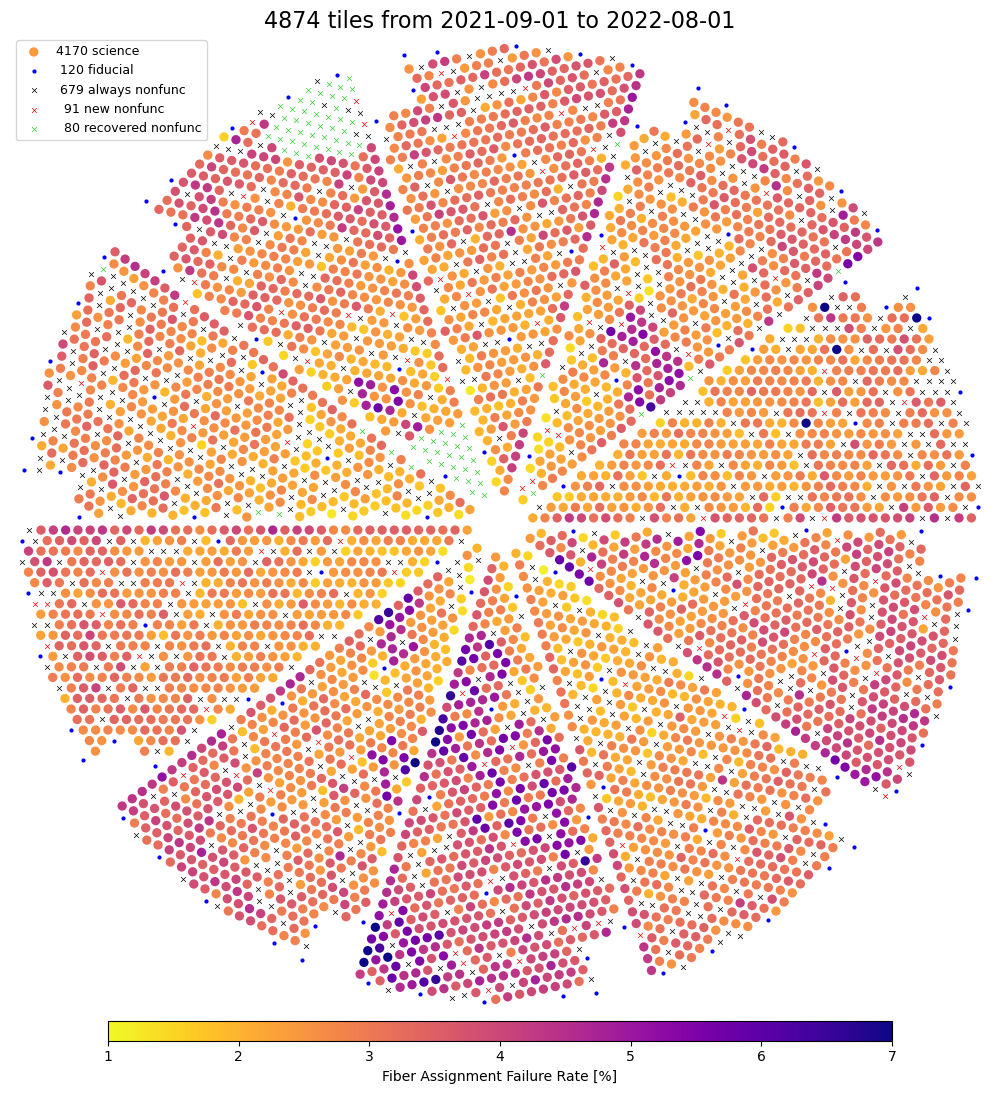

In [26]:
plot_unassigned('RUN1', save='RUN1.jpg')

Non-functional: 770 before, 814 after, 770 throughout, 44 new, 0


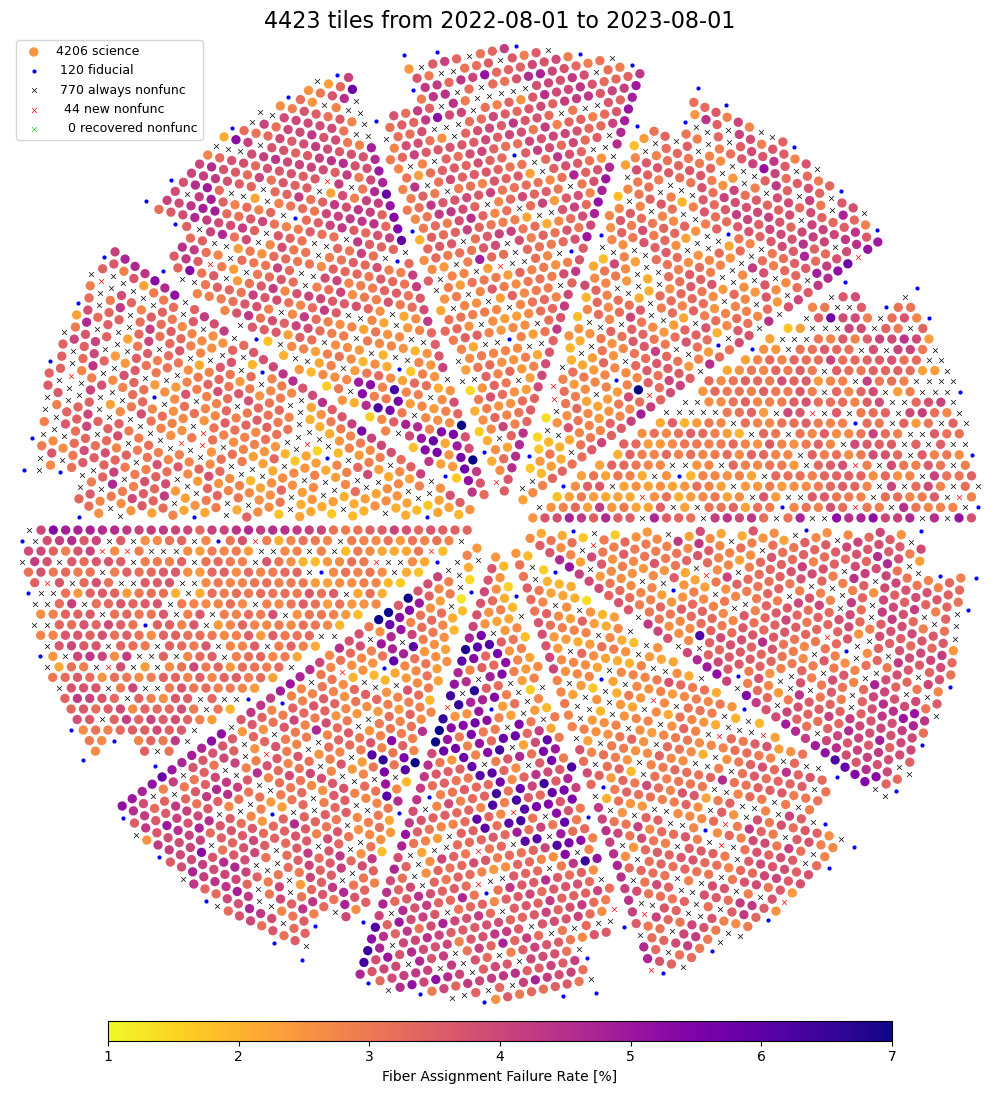

In [27]:
plot_unassigned('RUN2', save='RUN2.jpg')

Non-functional: 814 before, 840 after, 814 throughout, 26 new, 0


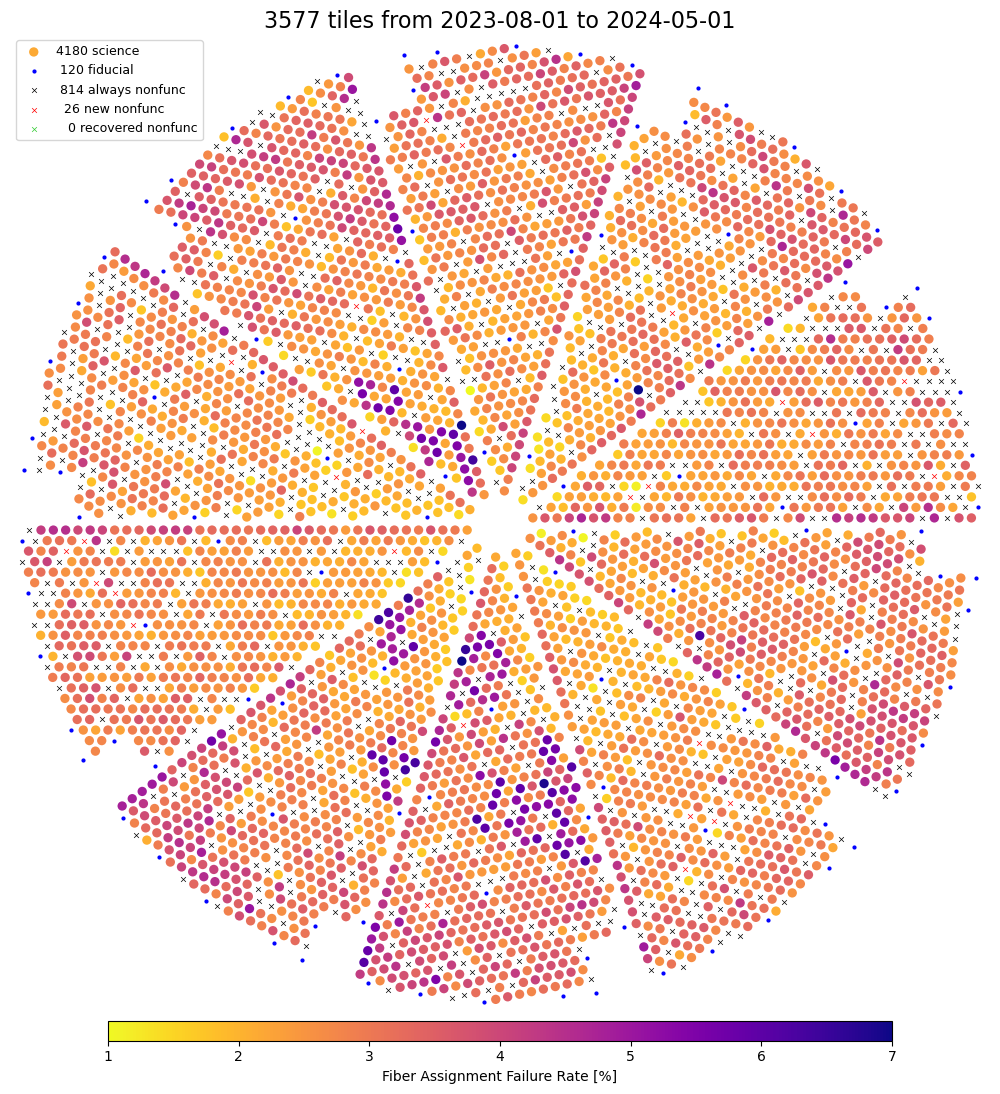

In [28]:
plot_unassigned('RUN3', save='RUN3.jpg')

Non-functional: 840 before, 625 after, 615 throughout, 10 new, 225


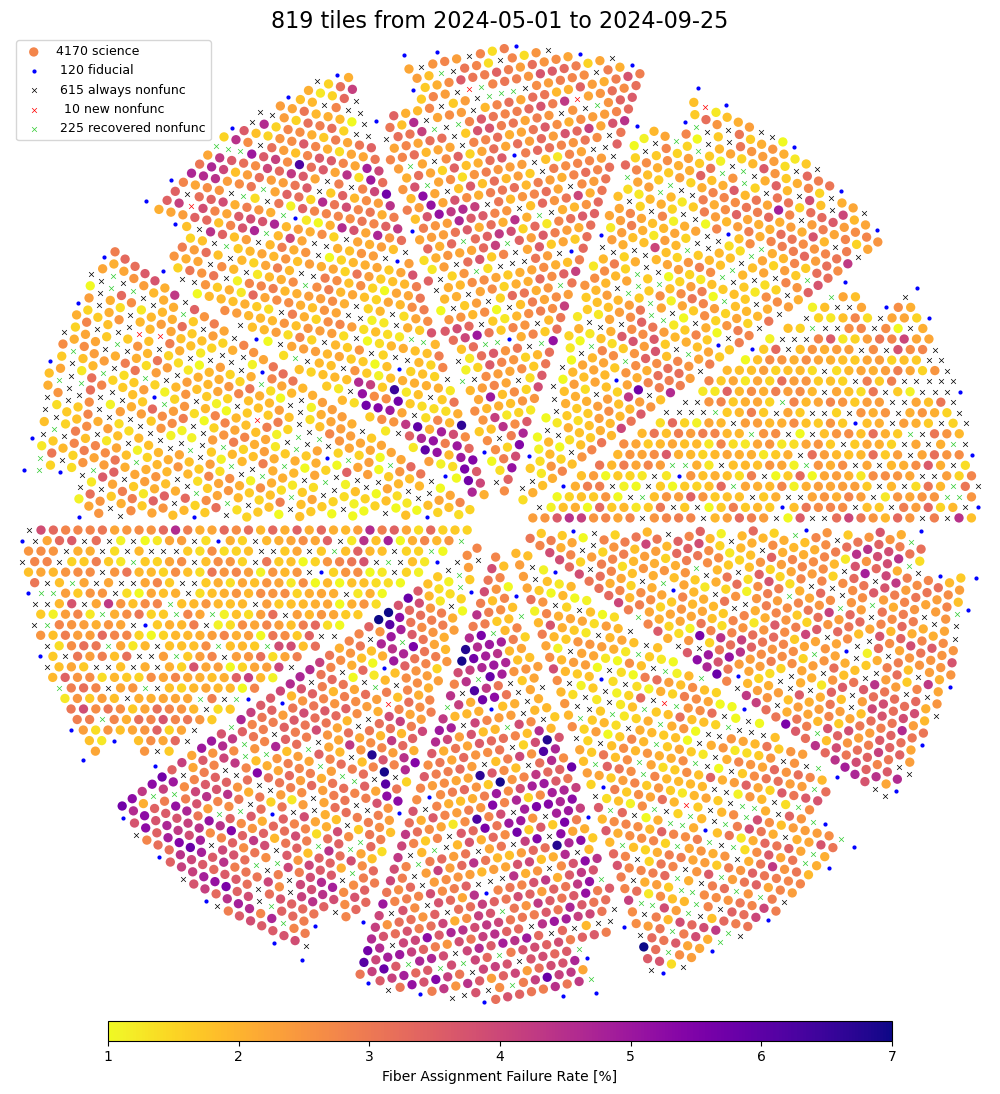

In [29]:
plot_unassigned('RUN4', save='RUN4.jpg')

Non-functional: 759 before, 625 after, 473 throughout, 152 new, 286


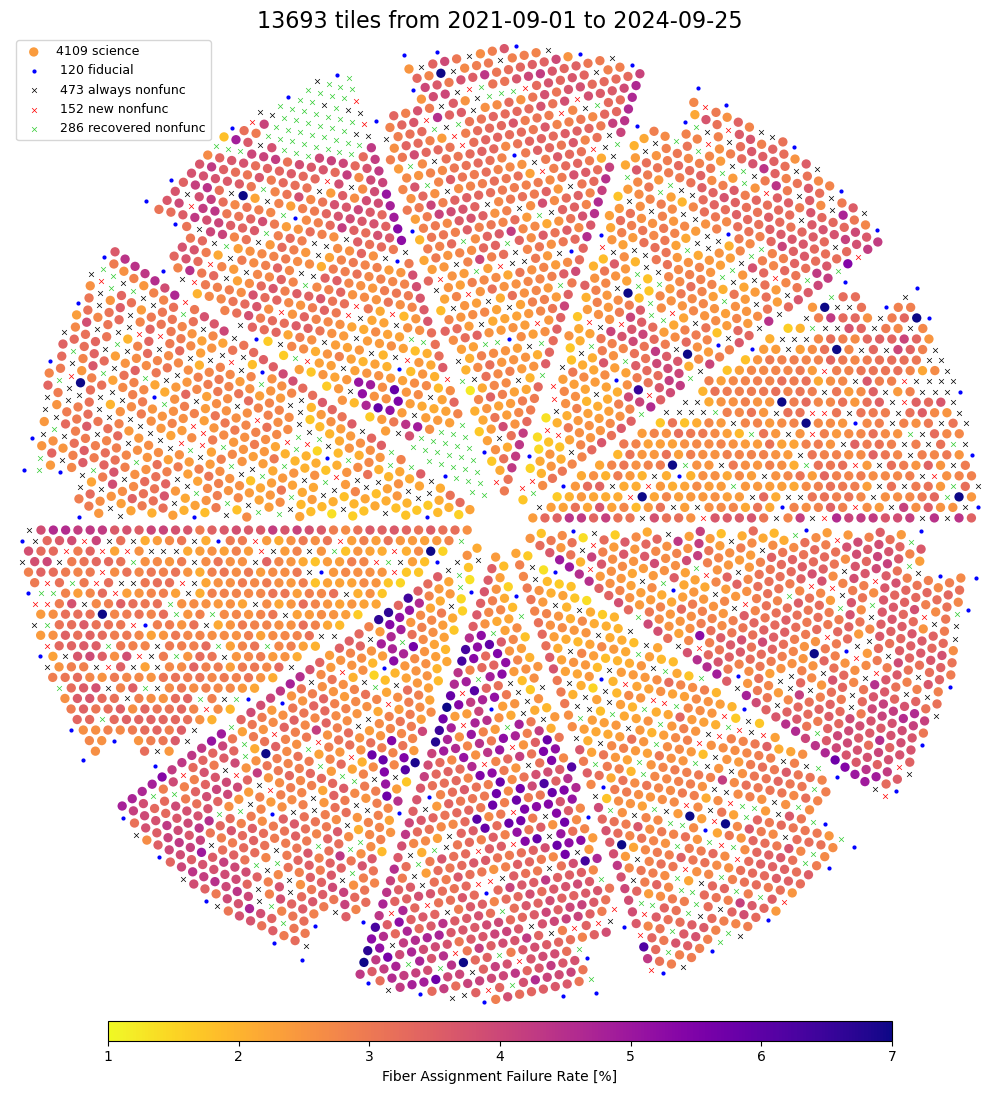

In [30]:
plot_unassigned('RUN1', 'RUN4', save='ALLRUNS.jpg')

### Petal Edges

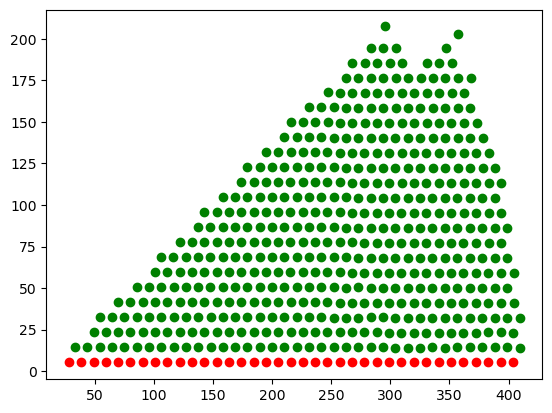

In [50]:
def get_edge_locs():
    
    design = fpoffline.const.get_petal_design()
    x_ptl, y_ptl = design.holes.X_PTL.to_numpy(), design.holes.Y_PTL.to_numpy()
    y0 = np.min(y_ptl)
    is_edge = y_ptl < y0 + 1
    plt.plot(x_ptl[~is_edge], y_ptl[~is_edge], 'go')
    plt.plot(x_ptl[is_edge], y_ptl[is_edge], 'ro')
    edge_locs = design.holes.DEVICE_LOC[is_edge].to_numpy()
    return edge_locs
    
edge_locs = get_edge_locs()

Non-functional: 814 before, 840 after, 814 throughout, 26 new, 0


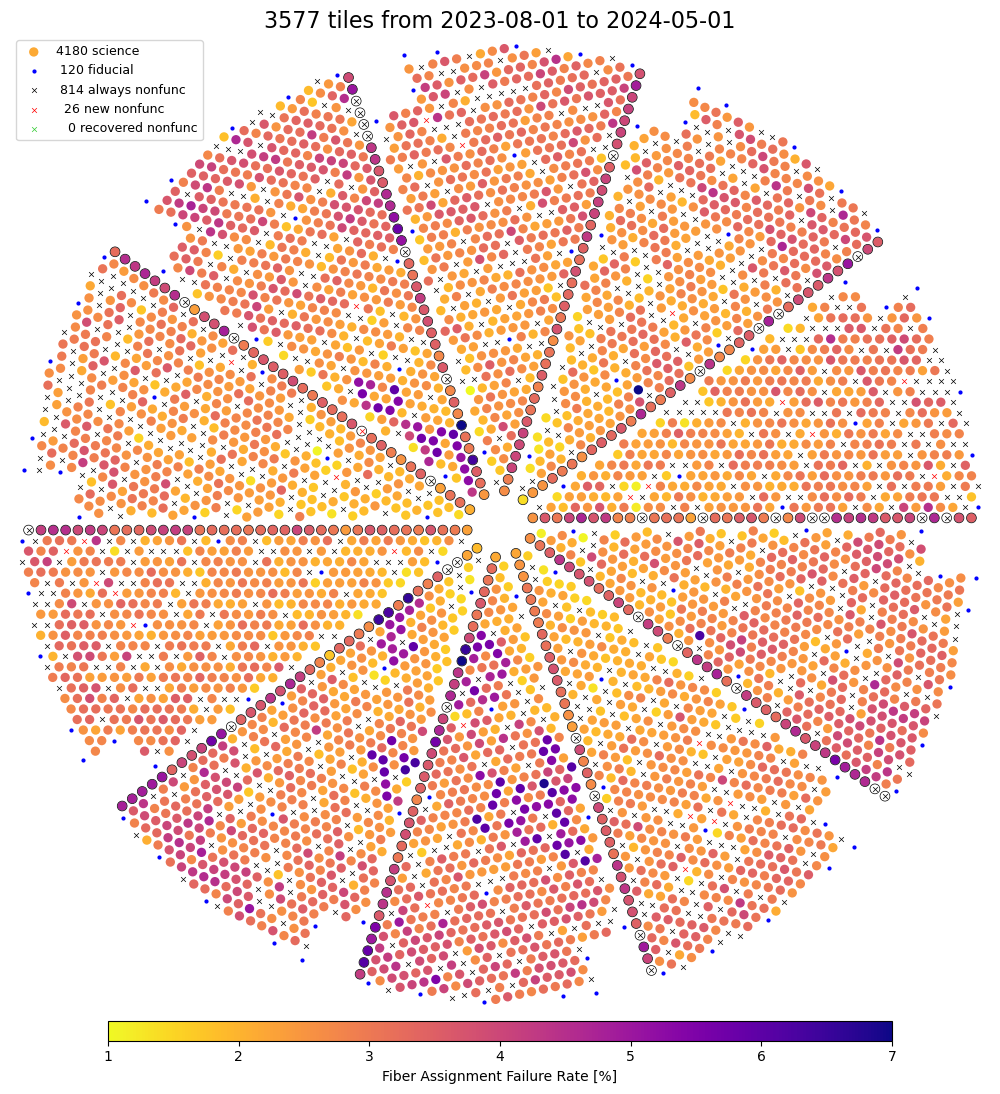

In [51]:
plot_unassigned('RUN3', show_edges=True, save='RUN3edges.jpg')

### Fiber Slit Block Structure

The slitblock ID values are B00 - B20, except for P6 which only has B00 - B19 (why??). B20 only has 2 fibers when it is present. Are these the ETC fibers?

In [750]:
FPINDEX[(FPINDEX.SLITBLOCK_ID == 'B20')].PETAL_LOC.unique()

array([0, 1, 2, 3, 4, 5, 7, 8, 9])

In [43]:
def average_slitblocks(FP, cut=4, verbose=False, plot=False):

    isnan = np.isnan(FP.data)
    cutlocs = [ ]
    values = [ ]
    ngoods = [ ]
    nbads = [ ]
    fracs = [ ]
    for petal_loc in range(10):
        sel = (FPINDEX.PETAL_LOC == petal_loc) & FPINDEX.SLITBLOCK_ID.notna()
        dlocs = FPINDEX[sel].DEVICE_LOC.to_numpy()
        bids = FPINDEX[sel].SLITBLOCK_ID
        for i in range(20): # ignore B20
            bid = f'B{i:02d}'
            bsel = bids == bid
            k = FP.locmap[dlocs[bsel]]
            nbad = np.count_nonzero(np.isnan(FP.data[petal_loc, k]))            
            mu = np.nanmean(FP.data[petal_loc, k])
            nbads.append(nbad)
            ngoods.append(len(k) - nbad)
            fracs.append(100 * mu)
            FP.data[petal_loc, k] = mu
            values.append(mu)
            if verbose or 100 * mu > cut or nbad == 0:
                print(f'P{petal_loc} {bid} with {len(k)} robots ({nbad} nonfunc) has {100*mu:.1f}% assignment failures')
                cutlocs.extend(1000 * petal_loc + dlocs[bsel])
                
    if plot:
        plt.plot(nbads, fracs, 'x')
        plt.grid()
        plt.xlabel('Number of non-functional robots in slitblock')
        plt.ylabel('Fiber assignment failure rate [%]')
        plt.savefig('slitblock-frac.jpg')
    FP.data[isnan] = np.nan
    return FP, cutlocs

P0 B00 with 25 robots (0 nonfunc) has 5.5% assignment failures
P0 B04 with 23 robots (0 nonfunc) has 3.2% assignment failures
P0 B05 with 25 robots (0 nonfunc) has 5.5% assignment failures
P0 B12 with 25 robots (1 nonfunc) has 4.3% assignment failures
P6 B17 with 25 robots (1 nonfunc) has 5.3% assignment failures
P9 B03 with 25 robots (0 nonfunc) has 5.4% assignment failures
P9 B09 with 25 robots (1 nonfunc) has 4.0% assignment failures


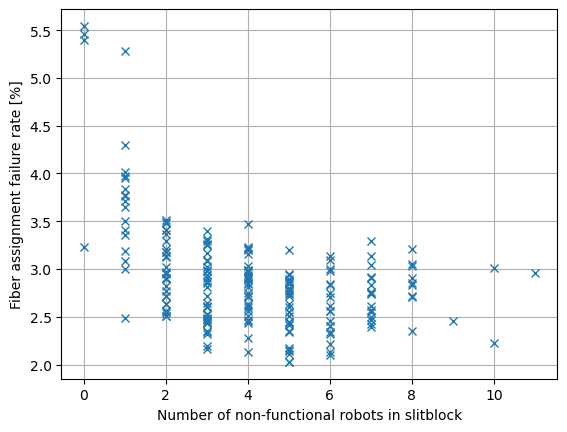

In [44]:
average_slitblocks(get_data('RUN3')[0], plot=True);

Non-functional: 814 before, 840 after, 814 throughout, 26 new, 0
P0 B00 with 25 robots has 5.5% assignment failures
P0 B05 with 25 robots has 5.5% assignment failures
P0 B12 with 25 robots has 4.3% assignment failures
P6 B17 with 25 robots has 5.3% assignment failures
P9 B03 with 25 robots has 5.4% assignment failures
P9 B09 with 25 robots has 4.0% assignment failures


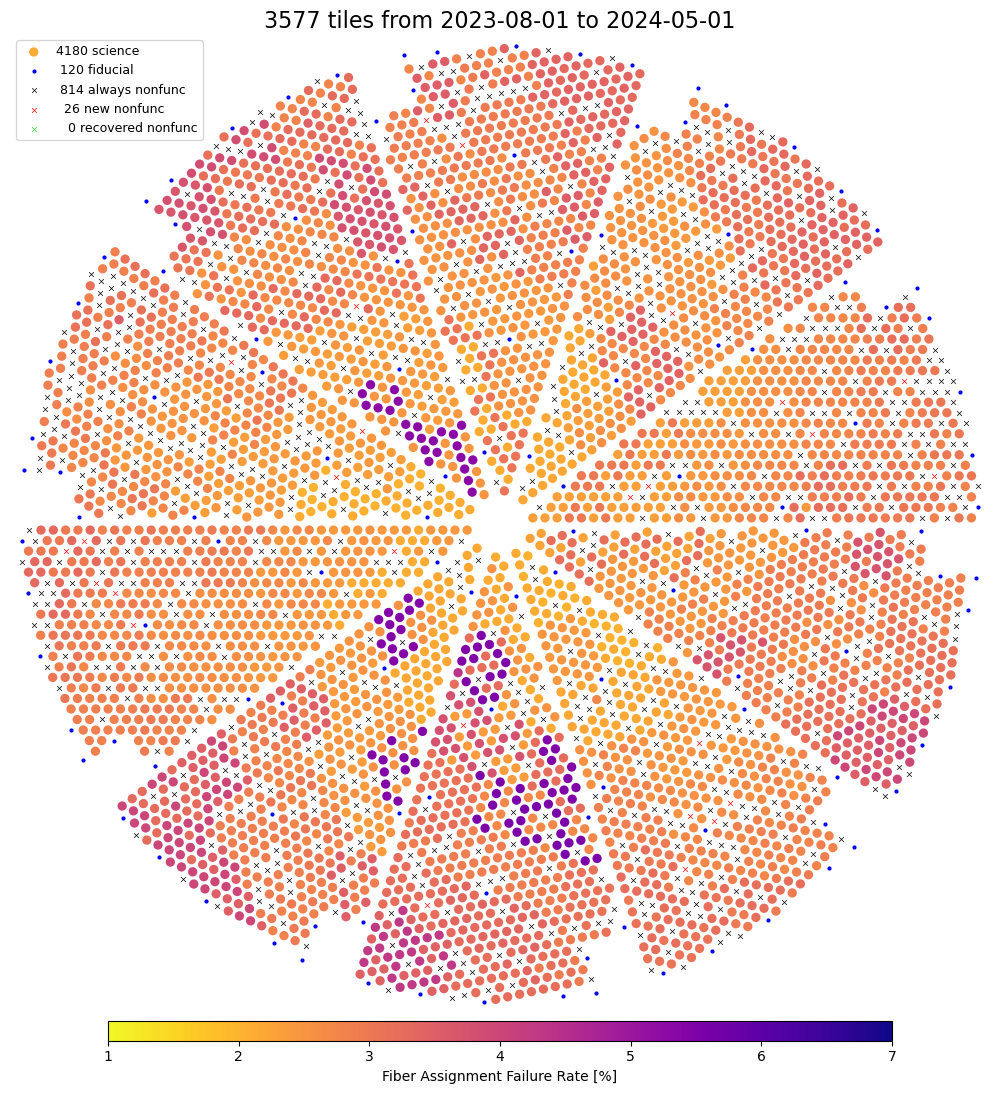

In [1017]:
plot_unassigned('RUN3', by_slitblock=True, save='RUN3slitblocks.jpg')

### Failure Rate vs Number of Functional Neighbors

In [45]:
def get_neighbors(max_neighbors=6, max_separation=12, sentinel_value=-1):
    
    design = fpoffline.const.get_petal_design()
    X, Y = design.holes.X_PTL.to_numpy(), design.holes.Y_PTL.to_numpy()
    dX = X.reshape(-1,1) - X
    dY = Y.reshape(-1,1) - Y
    separation = np.hypot(dX, dY)
    is_neighbor = (separation > 0) & (separation < max_separation)
    neighbors = np.full((len(X), max_neighbors), sentinel_value, int)
    for i, row in enumerate(is_neighbor):
        locs = np.flatnonzero(row)
        neighbors[i, :len(locs)] = locs
    return neighbors
    
neighbors = get_neighbors(sentinel_value=457) # = FP.locmap[461] = DEVICE_LOC of ETC fiber

In [46]:
def show_neighbors(loc, snap = snaps[-1][0]):
    
    design = fpoffline.const.get_petal_design()
    petal_loc = loc // 1000
    device_loc = loc % 1000
    idx = design.locmap[device_loc]
    neighbor_locs = 1000 * petal_loc + design.holes.DEVICE_LOC.to_numpy()[neighbors[idx]]
    
    snap_locs = 1000 * snap['PETAL_LOC'] + snap['DEVICE_LOC']
    
    row = snap[snap_locs == loc][0]
    print(row['POS_ID'])
    print(sorted(row['POS_NEIGHBORS']))
    
    neighbor_posids = [ ]
    neighbor_nonfunc = [ ]
    for loc in neighbor_locs:
        if loc in snap_locs:
            neighbor_posids.append(snap[snap_locs == loc][0]['POS_ID'])
            neighbor_nonfunc.append(snap[snap_locs == loc][0]['DEVICE_CLASSIFIED_NONFUNCTIONAL'])
        else:
            print(f'Missing loc {loc} in snapshot')
    neighbor_posids = np.array(neighbor_posids)
    neighbor_isfunc = ~np.array(neighbor_nonfunc)
    isort = np.argsort(neighbor_posids)
    print(list(neighbor_posids[isort]))
    print(neighbor_isfunc[isort])
    return np.count_nonzero(neighbor_isfunc)

show_neighbors(1342)

M05399
['M03858', 'M03998', 'M04207', 'M04782', 'M04977']
Missing loc 1321 in snapshot
['M03858', 'M03998', 'M04207', 'M04782', 'M04977']
[False  True False  True  True]


3

In [47]:
def plot_frac(start, stop=None, separate_edges=True, separate_blocks=True, plot_separate=True, save=None):
    
    FP, nonfunc_before, nonfunc_after, title = get_data(start, stop)
    
    num_functional_neighbors = np.zeros((10, 514), int)
    for petal_loc in range(10):
        # Count the number of functional neighbors of each robot for this petal
        is_neighbor_functional = np.isfinite(FP.data[petal_loc, neighbors])
        num_functional_neighbors[petal_loc] = np.count_nonzero(is_neighbor_functional, axis=1)
        
    # Do not include non-functional robots in the histograms
    num_functional_neighbors[~np.isfinite(FP.data)] = -1

    if separate_edges:
        # Do not include edge robots in the histograms
        k = FP.locmap[edge_locs]
        num_functional_neighbors[:, k] = -1
        # Save the fractions for functional edge robots to plot later
        edge_data = FP.data[:, k].ravel()
        edge_data = edge_data[np.isfinite(edge_data)]

    if separate_blocks:
        FPblock = fpoffline.array.DeviceArray()
        FPblock.data[:] = FP.data
        _, block_locs = average_slitblocks(FPblock)
        num_functional_neighbors[FP._decode(block_locs)] = -1
        block_data = FP[block_locs]
        block_data = block_data[np.isfinite(block_data)]

    fig, ax = plt.subplots(figsize=(8, 5))
    bins = np.linspace(0.5, 7.5, 29)
    groups = {
        'n<4': [ (1,2,3), dict(histtype='step', hatch='///', color='C0', alpha=0.75) ],
        'n=4': [ (4,), dict(histtype='step', color='C1', lw=2) ],
        'n=5': [ (5,), dict(histtype='step', color='C2', lw=2) ],
        'n=6': [ (6,), dict(histtype='stepfilled', color='C3', alpha=0.15) ],
    }
    ntot = 0
    for label, group in groups.items():
        nums, kwargs = group
        # Find robots with exactly n functional neighbors
        ploc, pidx = np.where(np.isin(num_functional_neighbors, nums))
        ngroup = len(ploc)
        ntot += ngroup
        print(f'Plotting {ngroup} robots with {label}')
        data = 100 * FP.data[ploc, pidx].ravel()
        mu = np.mean(data)
        ax.hist(data, bins=bins, label=f'{label} mean {mu:.1f}%', **kwargs)
        
    if separate_edges and plot_separate:
        # Plot the edge robots as a separate category
        n = len(edge_data)
        print(f'Plotting {n} robots on petal edges')
        mu = np.mean(100*edge_data)
        ax.hist(100*edge_data, bins=bins, label=f'edges mean {mu:.1f}%', histtype='step',
                hatch='||||', color='r', alpha=0.5)
        
    if separate_blocks and plot_separate:
        # Plot the hot slitblocks as a separate category
        n = len(block_data)
        print(f'Plotting {n} robots on hot fiberblocks')
        mu = np.mean(100*block_data)
        ax.hist(100*block_data, bins=bins, label=f'blocks mean {mu:.1f}%', histtype='stepfilled',
                color='c', alpha=0.5)
        ax.hist(100*block_data, bins=bins, histtype='step', lw=1, color='c')
        
    print(f'Plotted {ntot} total robots')
    ax.set(xlabel = 'Fiber assignment failure rate [%]', ylabel='Fibers with functional robots',
           xlim=(bins[0],bins[-1]), ylim=(0,240))
    ax.legend()
    plt.tight_layout()
    if save:
        plt.savefig(save)

Plotting 682 robots with n<4
Plotting 973 robots with n=4
Plotting 1367 robots with n=5
Plotting 1156 robots with n=6
Plotted 4178 total robots


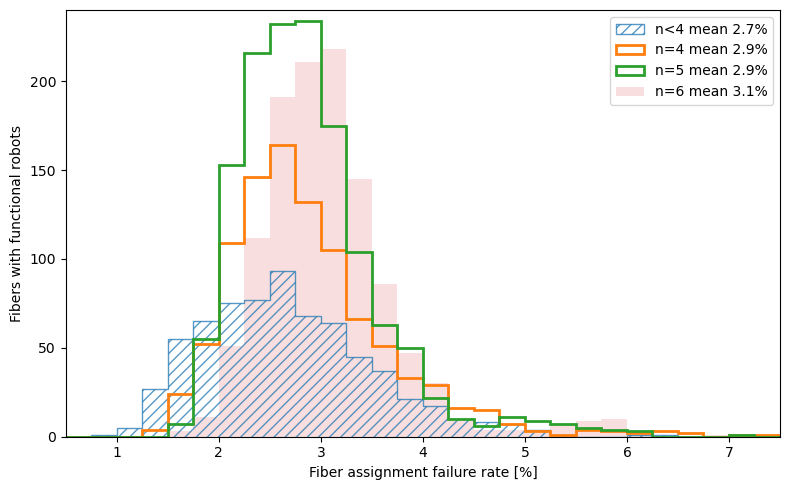

In [48]:
plot_frac('RUN3', separate_edges=False, separate_blocks=False, save='frac1.jpg')

Plotting 516 robots with n<4
Plotting 805 robots with n=4
Plotting 1367 robots with n=5
Plotting 1156 robots with n=6
Plotted 3844 total robots


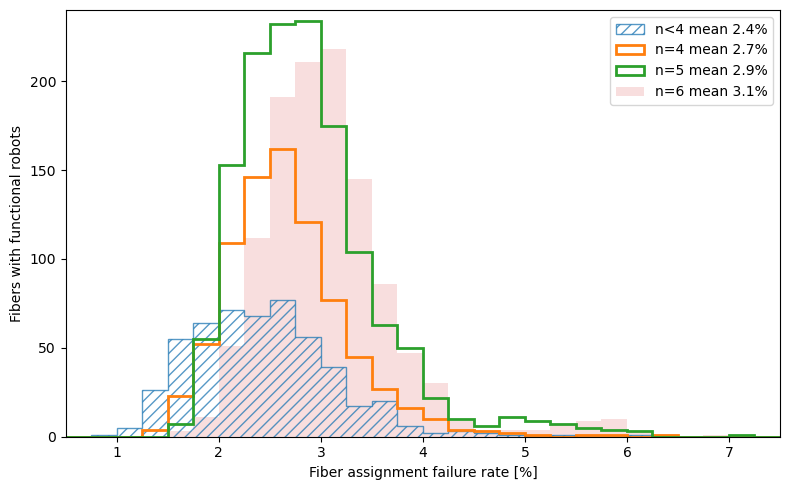

In [52]:
plot_frac('RUN3', separate_edges=True, separate_blocks=False, plot_separate=False, save='frac2.jpg')

P0 B00 with 25 robots (0 nonfunc) has 5.5% assignment failures
P0 B04 with 23 robots (0 nonfunc) has 3.2% assignment failures
P0 B05 with 25 robots (0 nonfunc) has 5.5% assignment failures
P0 B12 with 25 robots (1 nonfunc) has 4.3% assignment failures
P6 B17 with 25 robots (1 nonfunc) has 5.3% assignment failures
P9 B03 with 25 robots (0 nonfunc) has 5.4% assignment failures
P9 B09 with 25 robots (1 nonfunc) has 4.0% assignment failures
Plotting 502 robots with n<4
Plotting 791 robots with n=4
Plotting 1301 robots with n=5
Plotting 1095 robots with n=6
Plotted 3689 total robots


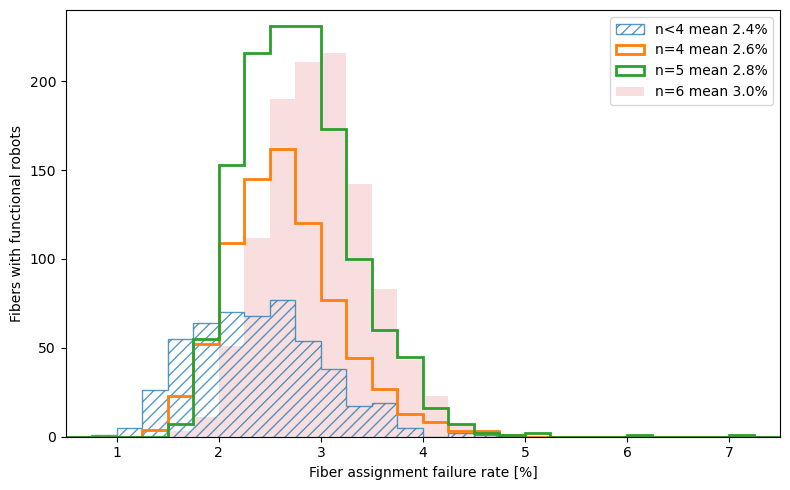

In [53]:
plot_frac('RUN3', separate_edges=True, separate_blocks=True, plot_separate=False, save='frac3.jpg')

P0 B00 with 25 robots (0 nonfunc) has 5.5% assignment failures
P0 B04 with 23 robots (0 nonfunc) has 3.2% assignment failures
P0 B05 with 25 robots (0 nonfunc) has 5.5% assignment failures
P0 B12 with 25 robots (1 nonfunc) has 4.3% assignment failures
P6 B17 with 25 robots (1 nonfunc) has 5.3% assignment failures
P9 B03 with 25 robots (0 nonfunc) has 5.4% assignment failures
P9 B09 with 25 robots (1 nonfunc) has 4.0% assignment failures
Plotting 502 robots with n<4
Plotting 791 robots with n=4
Plotting 1301 robots with n=5
Plotting 1095 robots with n=6
Plotting 334 robots on petal edges
Plotting 170 robots on hot fiberblocks
Plotted 3689 total robots


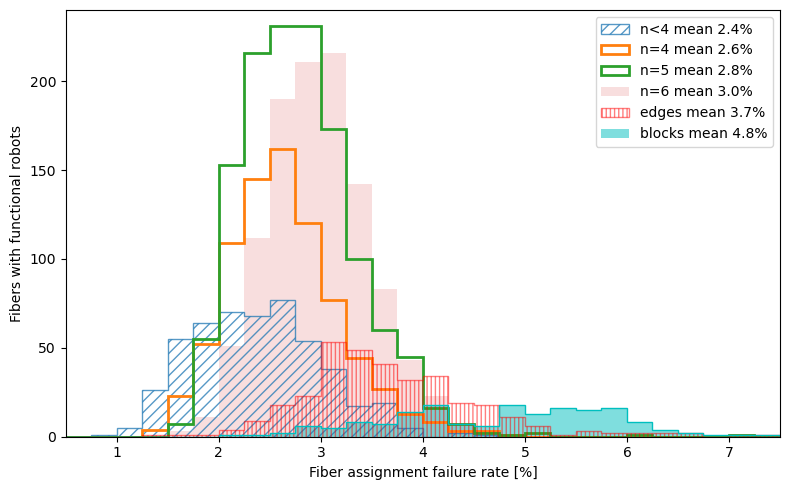

In [54]:
plot_frac('RUN3', separate_edges=True, separate_blocks=True, plot_separate=True, save='frac3.jpg')

### Assignment Failure Rate vs Phi Keepout Expansion

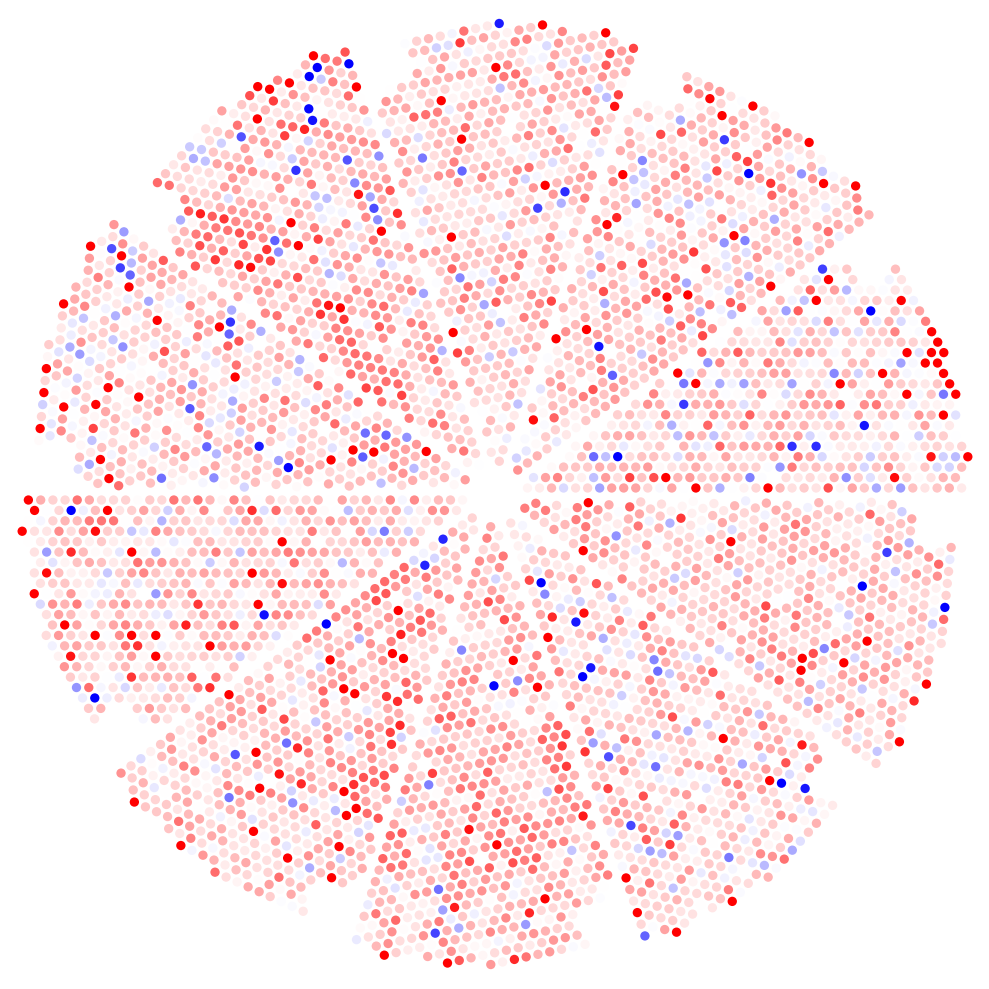

In [55]:
def plot_phi_expansion(snap=snaps[2][0], save=None):
    
    r1 = np.asarray(snap['LENGTH_R1'])
    r2 = np.asarray(snap['LENGTH_R2'])
    dr = np.asarray(snap['KEEPOUT_EXPANSION_PHI_RADIAL'])
    drtot = (r1 - 3) + np.abs(r2 - 3) + 2 * dr
    dA = np.deg2rad(snap['KEEPOUT_EXPANSION_PHI_ANGULAR'])
    drtot = (r1 - 3) + np.abs(r2 - 3) + 2 * dr + 1 * dA
    
    #plt.hist(drtot.ravel(), bins=np.linspace(-0.3,0.45, 50))
    
    locs = np.asarray(1000 * snap['PETAL_LOC'] + snap['DEVICE_LOC'])
    
    FP = fpoffline.array.DeviceArray(POS=True, ETC=True)
    FP[locs] = drtot
    x, y = FP.xy(locs)
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set(aspect=1, xlim=(-420,420), ylim=(-420,420))
    ax.axis('off')
    
    ax.scatter(x, y, c=drtot, lw=0, s=45, cmap='bwr', vmin=-0.35, vmax=0.35)

    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_phi_expansion(save='phi_expansion.jpg')

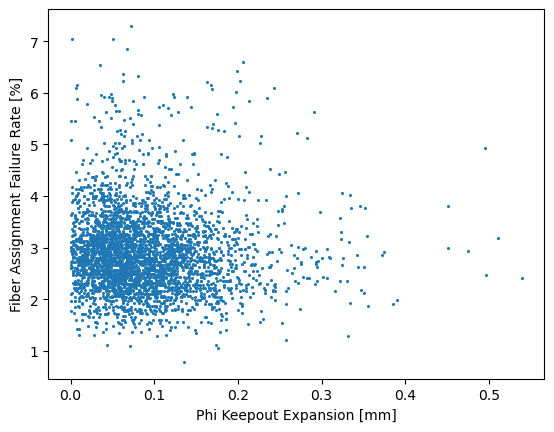

In [56]:
def plot_phi_correlation(start, stop=None):

    FP, nonfunc_before, nonfunc_after, title = get_data(start, stop)
    nonfunc_any = list(nonfunc_before | nonfunc_after)
    FP[nonfunc_any] = np.nan
    
    run_names = sorted(list(RUNS.keys()))
    start = run_names.index(start)
    snap = snaps[start][0]
    r1 = np.asarray(snap['LENGTH_R1'])
    r2 = np.asarray(snap['LENGTH_R2'])
    dr = np.asarray(snap['KEEPOUT_EXPANSION_PHI_RADIAL'])
    dA = np.deg2rad(snap['KEEPOUT_EXPANSION_PHI_ANGULAR'])
    drtot = (r1 - 3) + np.abs(r2 - 3) + 2 * dr + 1 * dA

    locs = np.asarray(1000 * snap['PETAL_LOC'] + snap['DEVICE_LOC'])
    
    FP2 = fpoffline.array.DeviceArray(POS=True, ETC=True)
    FP2[locs] = drtot
    
    sel = np.isfinite(FP.data) & (FP2.data > 0)
    plt.scatter(FP2.data[sel], 100 * FP.data[sel], lw=0, s=5)
    plt.xlabel('Phi Keepout Expansion [mm]')
    plt.ylabel('Fiber Assignment Failure Rate [%]')
    
plot_phi_correlation('RUN3')

### Isolated Outliers

In [57]:
def get_outliers(start, stop=None, cut=5, separate_edges=True, separate_blocks=True):
    
    FP, nonfunc_before, nonfunc_after, title = get_data(start, stop)
    
    if separate_edges:
        # Do not include edge robots in the histograms
        k = FP.locmap[edge_locs]
        FP.data[:, k] = np.nan

    if separate_blocks:
        FPblock = fpoffline.array.DeviceArray()
        FPblock.data[:] = FP.data
        _, block_locs = average_slitblocks(FPblock)
        FP[block_locs] = np.nan

    outliers = FP.where(lambda f: 100 * f > cut)
    
    for loc in outliers:
        ploc = loc // 1000
        dloc = loc % 1000
        sel = (FPINDEX.PETAL_LOC == ploc) & (FPINDEX.DEVICE_LOC == dloc)
        assert np.count_nonzero(sel) == 1
        row = FPINDEX[sel].iloc[0]
        print(f'{row.DEVICE_ID} at loc {loc} fiber {row.FIBER_ID} has {100*FP[[loc]][0]:.1f}% assignment failure rate')
    
    return outliers

outlier_locs = get_outliers('RUN3')

P0 B00 with 25 robots (0 nonfunc) has 5.5% assignment failures
P0 B05 with 25 robots (2 nonfunc) has 5.3% assignment failures
P0 B12 with 25 robots (4 nonfunc) has 4.1% assignment failures
P6 B17 with 25 robots (3 nonfunc) has 5.1% assignment failures
P9 B03 with 25 robots (3 nonfunc) has 5.3% assignment failures
M05661 at loc 2103 fiber 1255 has 6.2% assignment failure rate
M05333 at loc 4073 fiber 2470 has 7.0% assignment failure rate
M07086 at loc 6098 fiber 3402 has 5.2% assignment failure rate
M07048 at loc 9507 fiber 4827 has 5.0% assignment failure rate


Some example tiles from RUN3 where M05333 failed to get a target:
 - 42271, 23804, 5847, 1719, 21598, 9357, 9708, 3583, 3804, 11399

Found 38 targets reachable by L4073 in tile 23804


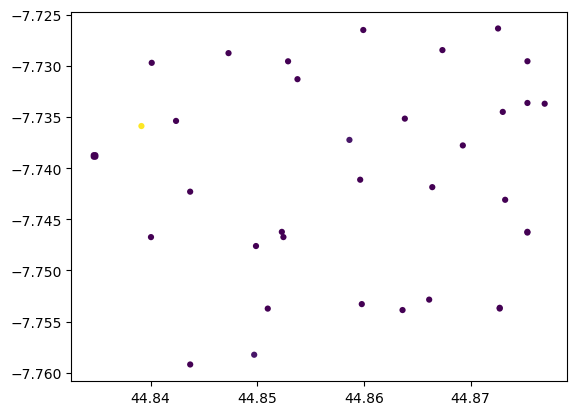

In [58]:
def plot_targets(tileid, loc):
    
    tag = str(tileid).zfill(6)
    path = FA_PATH / tag[:3] / f'fiberassign-{tag}.fits.gz'
    with fitsio.FITS(str(path)) as hdus:
        potl = hdus['POTENTIAL_ASSIGNMENTS'].read()
        sel = potl['LOCATION'] == loc
        nsel = np.count_nonzero(sel)
        print(f'Found {nsel} targets reachable by L{loc} in tile {tileid}')
        targets = hdus['TARGETS'][['TARGETID', 'RA', 'DEC', 'PRIORITY']].read()
        isort = np.argsort(targets['TARGETID'])
        idx = np.searchsorted(targets['TARGETID'], potl['TARGETID'][sel], sorter=isort)
        assert np.all(targets['TARGETID'][idx] == potl['TARGETID'][sel])
        plt.scatter(targets['RA'][idx], targets['DEC'][idx], s=20, lw=0, c=targets['PRIORITY'][idx])
        
plot_targets(23804, 4073)